In [1]:
import os
import munch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [34]:
def mch(**kwargs):
    return munch.Munch(dict(**kwargs))

In [35]:
def configure_metadata(metadata_root):
    metadata = mch()
    metadata.image_ids = os.path.join(metadata_root, 'image_ids.txt')
    metadata.image_ids_proxy = os.path.join(metadata_root,
                                            'image_ids_proxy.txt')
    metadata.class_labels = os.path.join(metadata_root, 'class_labels.txt')
    metadata.image_sizes = os.path.join(metadata_root, 'image_sizes.txt')
    metadata.localization = os.path.join(metadata_root, 'localization.txt')
    return metadata

In [36]:
data_root = '../src/dataset'
metadata_root = '../src/metadata'
dataset_list = ['CUB', 'ILSVRC']
_SPLITS = ('train', 'val', 'test')
metadata_cub_path = os.path.join(metadata_root, 'CUB')
metadata_cub_splits = {split: configure_metadata(os.path.join(metadata_cub_path, split)) for split in _SPLITS}

In [37]:
def get_class_labels(metadata):
    """
    image_ids.txt has the structure

    <path>,<integer_class_label>
    path/to/image1.jpg,0
    path/to/image2.jpg,1
    path/to/image3.jpg,1
    ...
    """
    class_labels = {}
    with open(metadata.class_labels) as f:
        for line in f.readlines():
            image_id, class_label_string = line.strip('\n').split(',')
            class_labels[image_id] = int(class_label_string)
    return class_labels

In [38]:
def get_bounding_boxes(metadata):
    """
    localization.txt (for bounding box) has the structure

    <path>,<x0>,<y0>,<x1>,<y1>
    path/to/image1.jpg,156,163,318,230
    path/to/image1.jpg,23,12,101,259
    path/to/image2.jpg,143,142,394,248
    path/to/image3.jpg,28,94,485,303
    ...

    One image may contain multiple boxes (multiple boxes for the same path).
    """
    boxes = {}
    with open(metadata.localization) as f:
        for line in f.readlines():
            image_id, x0s, y0s, x1s, y1s = line.strip('\n').split(',')
            x0, y0, x1, y1 = int(x0s), int(y0s), int(x1s), int(y1s)
            if image_id in boxes:
                boxes[image_id].append((x0, y0, x1, y1))
            else:
                boxes[image_id] = [(x0, y0, x1, y1)]
    return boxes

In [43]:
labels = get_class_labels(metadata_cub_splits['test'])
cub_train_labels = {'id': labels.keys(), 'label': labels.values()}

In [44]:
df = pd.DataFrame.from_dict(cub_train_labels)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5794 entries, 0 to 5793
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5794 non-null   object
 1   label   5794 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.7+ KB


In [42]:
df.groupby(df.label).count().describe()

,id
count,200.000000
mean,29.970000
std,0.171015
min,29.000000
25%,30.000000
50%,30.000000
75%,30.000000
max,30.000000


In [63]:
metadata_path = os.path.join(metadata_root, 'CUB')
metadata_splits = {split: configure_metadata(os.path.join(metadata_cub_path, split)) for split in _SPLITS}

for dataset in dataset_list:
    metadata_path = os.path.join(metadata_root, dataset)
    metadata_splits = {split: configure_metadata(os.path.join(metadata_path, split)) for split in _SPLITS}
    for split in _SPLITS:
        labels = get_class_labels(metadata_splits[split])
        boxes = get_bounding_boxes(metadata_splits[split])
        boxes_len = list(map(len, boxes.values()))
        if not boxes_len:
            boxes_len = [0] * len(labels)
        info = {'images': labels.keys(), 'labels': labels.values(), 'boxes': boxes_len}
        _min = min(boxes_len) if boxes_len else 0
        _max = max(boxes_len) if boxes_len else 0
        _max_image = list(boxes.keys())[boxes_len.index(_max)] if _max > 1 else ''
        print()
        print(f'{dataset} {split}: images = {len(labels)} classes = {len(set(labels.values()))}')
        df = pd.DataFrame.from_dict(info)
        df_grp_lbl = df.groupby(df.labels).agg({'images': 'count', 'boxes': 'max'})
        print(df_grp_lbl.describe().T)


CUB train: images = 5994 classes = 200
        count   mean       std   min   25%   50%   75%   max
images  200.0  29.97  0.171015  29.0  30.0  30.0  30.0  30.0
boxes   200.0   1.00  0.000000   1.0   1.0   1.0   1.0   1.0

CUB val: images = 1000 classes = 200
        count  mean      std  min  25%  50%  75%  max
images  200.0   5.0  0.17364  3.0  5.0  5.0  5.0  6.0
boxes   200.0   1.0  0.00000  1.0  1.0  1.0  1.0  1.0

CUB test: images = 5794 classes = 200
        count   mean       std   min   25%   50%   75%   max
images  200.0  28.97  2.920917  11.0  29.0  30.0  30.0  30.0
boxes   200.0   1.00  0.000000   1.0   1.0   1.0   1.0   1.0

ILSVRC train: images = 1281167 classes = 1000
         count      mean        std    min     25%     50%     75%     max
images  1000.0  1281.167  70.221807  732.0  1300.0  1300.0  1300.0  1300.0
boxes   1000.0     0.000   0.000000    0.0     0.0     0.0     0.0     0.0

ILSVRC val: images = 10000 classes = 1000
         count    mean        std   min 

In [102]:
split = 'test'
dataset = 'ILSVRC'
metadata_path = os.path.join(metadata_root, dataset)
metadata_splits = {split: configure_metadata(os.path.join(metadata_path, split)) for split in _SPLITS}
labels = get_class_labels(metadata_splits[split])
boxes = get_bounding_boxes(metadata_splits[split])
boxes_len = list(map(len, boxes.values()))
if not boxes_len:
    boxes_len = [0] * len(labels)
info = {'images': labels.keys(), 'labels': labels.values(), 'boxes': boxes_len}
print(f'{dataset} {split}: images = {len(labels)} classes = {len(set(labels.values()))}')
df = pd.DataFrame.from_dict(info)

ILSVRC test: images = 50000 classes = 1000


In [109]:
df.describe()

,labels,boxes
count,50000.000000,50000.000000
mean,499.500000,1.609540
std,288.677877,1.759029
min,0.000000,1.000000
25%,249.750000,1.000000
50%,499.500000,1.000000
75%,749.250000,1.000000
max,999.000000,20.000000


In [87]:
df2 = df.groupby(df.boxes).agg({'images': 'count', 'labels': 'unique'})
df2['labels'] = df2.labels.map(len)

In [93]:
print(df2)

       images  labels
boxes                
1       38285    1000
2        6128     963
3        2103     713
4        1106     514
5         668     363
6         438     278
7         290     203
8         214     148
9         150     119
10        128      93
11         97      81
12         93      78
13         66      57
14         46      44
15         50      42
16         38      30
17         26      24
18         40      35
19         22      20
20         12      12


<AxesSubplot: xlabel='boxes'>

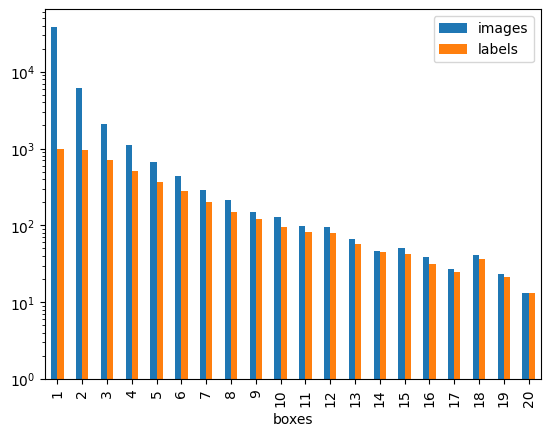

In [98]:
df2.plot.bar(log=True)

In [34]:
z = np.random.random((6,2))
zmask = np.ones((len(e),len(g)), dtype=bool)

In [23]:
g = np.arange(2)
gmask = np.ones(len(g), dtype=bool)

In [24]:
e = np.arange(6)
emask = np.ones(len(e), dtype=bool)

In [109]:
number_of_box_list = [2,2,2]
num_threshold = len(number_of_box_list)
iou_threshold = 0.5
num_correct = {iou_threshold: np.zeros(shape=(3, z.shape[1]))}
num_correct_aggregated = {iou_threshold: np.zeros(shape=(3,))}
num_gt_boxes = 0

idx = 0
sliced_multiple_iou = []
sliced_multiple_iou_index = []
y = z.copy()
for nr_box in number_of_box_list:
    gt_iou_max_index = []
    gt_iou_max = []
    x = y[idx:idx+nr_box]
    for g_index in range(x.shape[1]):
        max_iou_index = np.unravel_index(np.argmax(x), shape=x.shape)
        gt_iou_max_index.append((max_iou_index[0] + idx, max_iou_index[1]))
        gt_iou_max.append(x[max_iou_index[0],max_iou_index[1]])
        x[max_iou_index[0], :] = 0
        x[:, max_iou_index[1]] = 0
    sliced_multiple_iou.append(np.asarray(gt_iou_max))
    sliced_multiple_iou_index.append(gt_iou_max_index)
    idx += nr_box
num_gt_boxes += len(g)

In [110]:
sliced_multiple_iou

[array([0.84180655, 0.72144019]),
 array([0.83656069, 0.181785  ]),
 array([0.77082073, 0.46672577])]

In [111]:
multi_iou_per_threshold = np.asarray(sliced_multiple_iou)
multi_iou_per_threshold

array([[0.84180655, 0.72144019],
       [0.83656069, 0.181785  ],
       [0.77082073, 0.46672577]])

In [112]:
multi_iou_max_threshold = multi_iou_per_threshold[np.average(multi_iou_per_threshold, axis=1).argmax()]
multi_iou_max_threshold

array([0.84180655, 0.72144019])

In [113]:
correct_threshold_indices = np.where(multi_iou_per_threshold > 0.5)
correct_threshold_indices

(array([0, 0, 1, 2]), array([0, 1, 0, 0]))

In [114]:
for threshold in [0.5]:
    num_correct[threshold][correct_threshold_indices] += 1
    num_correct_aggregated[threshold] = np.sum(num_correct[threshold], axis=1)

In [115]:
num_correct

{0.5: array([[1., 1.],
        [1., 0.],
        [1., 0.]])}

In [116]:
num_correct_aggregated

{0.5: array([2., 1., 1.])}

In [3]:
img = mpimg.imread('stinkbug.png')

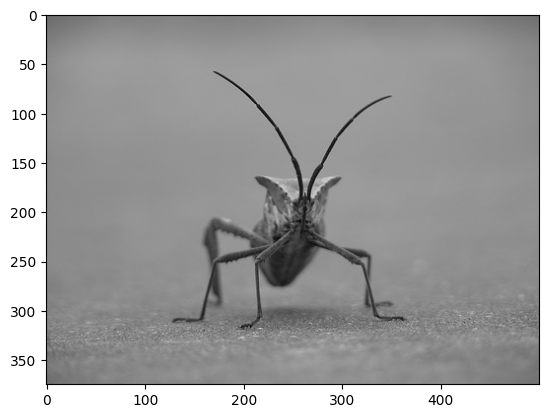

In [19]:
plt.imshow(img)

In [26]:
mpimg.imsave('stinkbug2.png', img)